In [1]:
import pandas as pd
import numpy as np
import subfunc as sf
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

In [46]:
DATA_DIR = 'data/'
DATA = 'evras.csv'

SOURCE_DIR = 'source/'
FINAL_STAGE_DIR = 'final_stage/'
target_columns = ['сыпуч известь РП']

In [3]:
data = pd.read_csv(f'{DATA_DIR}{DATA}', index_col='index', sep=';', decimal=',')

 * Нахождение самой популярной марки

In [4]:
top_mark = data.describe(include='all').loc["top", "МАРКА"]
print("Самая популярная марка - ", top_mark)

Самая популярная марка -  Э76ХФ


* Переводим дату во время изготовления сплава

In [5]:
data['DT'] = sf.date_to_interval(data['DT'])

In [6]:
dropped_data = sf.drop_columns(data,0.65)
marked_data = dropped_data[dropped_data['МАРКА'] == top_mark]
marked_data = marked_data.drop(columns= ['nplv', 'ПРОФИЛЬ', 'МАРКА'])

Удаленные колонки: N2 (интенс.), расход газ  N2, расход C пров., сыпуч кварцит, сыпуч  кокс. мелочь (сух.), ферспл FeMo, ферспл FeSi-75, ферспл FeV азот., ферспл  Ni H1 пласт., ферспл  ферванит


In [7]:
marked_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4953 entries, 0 to 7026
Data columns (total 71 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   DT                              4953 non-null   float64
 1   t вып-обр                       4432 non-null   float64
 2   t обработка                     4429 non-null   float64
 3   t под током                     4429 non-null   float64
 4   t продувка                      4432 non-null   float64
 5   ПСН гр.                         3590 non-null   float64
 6   чист расход C                   4426 non-null   float64
 7   чист расход Cr                  4417 non-null   float64
 8   чист расход Mn                  4423 non-null   float64
 9   чист расход Si                  4423 non-null   float64
 10  чист расход V                   4414 non-null   float64
 11  температура первая              4428 non-null   float64
 12  температура последняя           44

* Удаляем строки, где пропущены значения для целевых переменных

In [8]:
marked_data = marked_data.dropna(axis = 0,subset = target_columns)

In [9]:
marked_data = sf.fill_empty_values(marked_data)

In [10]:
marked_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3284 entries, 3 to 7026
Data columns (total 71 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   DT                              3284 non-null   float64
 1   t вып-обр                       3284 non-null   float64
 2   t обработка                     3284 non-null   float64
 3   t под током                     3284 non-null   float64
 4   t продувка                      3284 non-null   float64
 5   ПСН гр.                         3284 non-null   float64
 6   чист расход C                   3284 non-null   float64
 7   чист расход Cr                  3284 non-null   float64
 8   чист расход Mn                  3284 non-null   float64
 9   чист расход Si                  3284 non-null   float64
 10  чист расход V                   3284 non-null   float64
 11  температура первая              3284 non-null   float64
 12  температура последняя           32

In [11]:
normalized_data = sf.normalize_data(marked_data)
del marked_data

In [12]:
#sns_plot = sns.pairplot(normalized_data,
#                    x_vars=normalized_data.columns,
#                    y_vars=target_columns)
#sns_plot.savefig(f'{SOURCE_DIR}{FINAL_STAGE_DIR}multi_map_preprocessing.png')

In [13]:
dispersion = normalized_data.var()
#dispersion_ax = dispersion.sort_values().plot(kind='barh', figsize=(13, 25), grid=True)
#dispersion_fig = dispersion_ax.get_figure()
#dispersion_fig.savefig(f'{SOURCE_DIR}{FINAL_STAGE_DIR}dispersion_bar_preprocessing.png')

In [14]:
columns_to_drop = dispersion[dispersion < 0.001].index.to_list()
normalized_data = normalized_data.drop(columns=columns_to_drop)

* Графики корреляций

In [33]:
corr_data = normalized_data.corr()

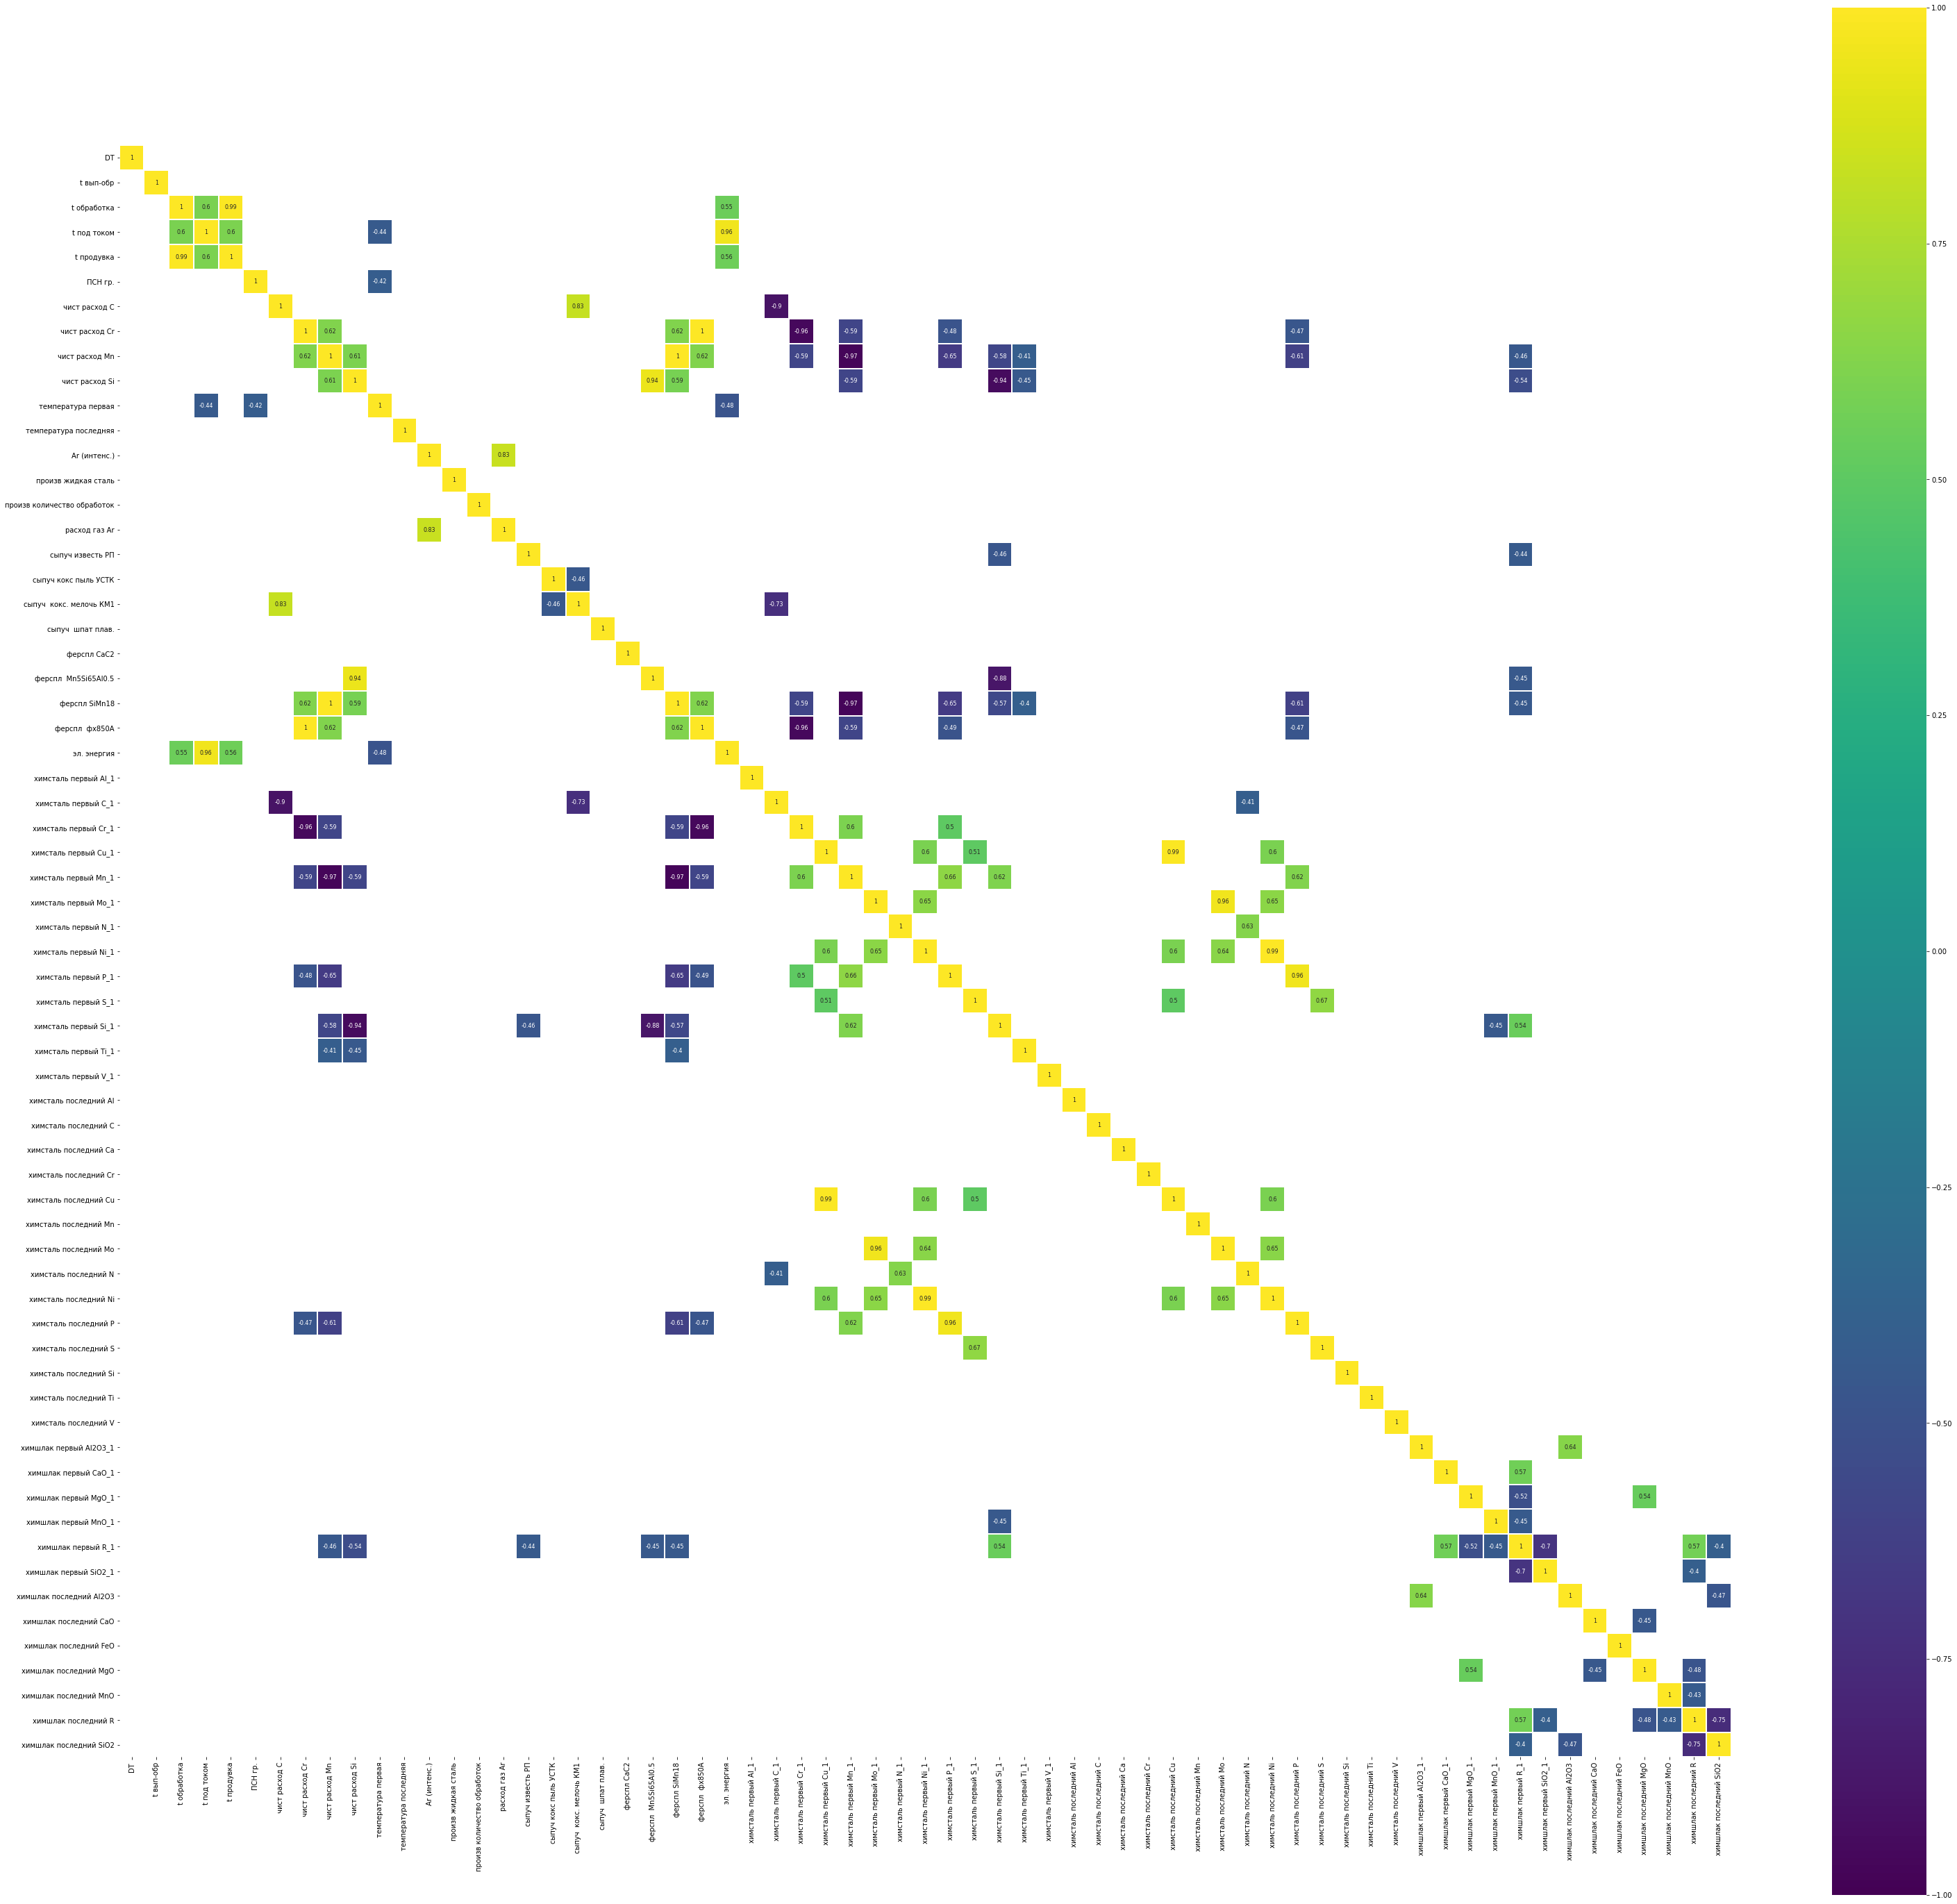

In [34]:
plt.figure(figsize=(52, 50))
sns.heatmap(corr_data[(corr_data >= 0.5) | (corr_data <= -0.4)],
       cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
       annot=True, annot_kws={"size": 8}, square=True)
plt.savefig(f'{SOURCE_DIR}{FINAL_STAGE_DIR}correlation_map.png')
plt.show()

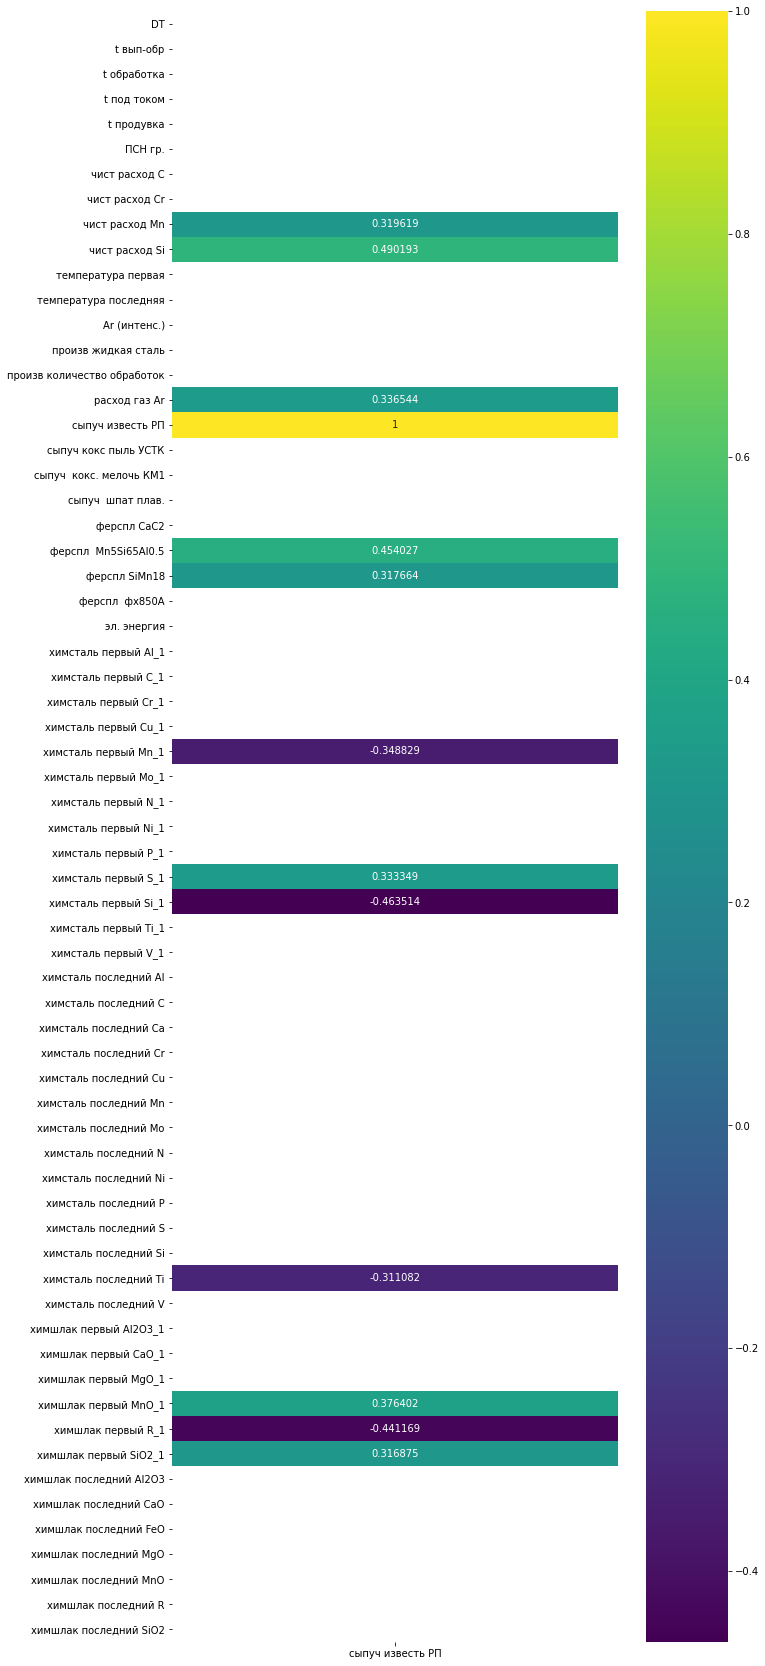

In [36]:
corr_target_data = corr_data['сыпуч известь РП']
corr_df = pd.DataFrame(corr_target_data.values, columns=target_columns, index=corr_data.index)
plt.figure(figsize=(10, 30))
sns.heatmap(corr_df[(corr_df >= 0.3) | (corr_df <= -0.3)], annot=True, fmt="g", cmap='viridis')
plt.savefig(f'{SOURCE_DIR}{FINAL_STAGE_DIR}correlation_target_map.png')
plt.show()

In [37]:
useless_list = []
for ind in corr_data.index:
    for col in corr_data.columns:
        if ind != col and abs(corr_data.loc[ind, col] >= 0.8 ):
            if [col, ind, corr_data.loc[ind, col]] not in useless_list:
                useless_list.append([ind, col, corr_data.loc[ind, col]])

del corr_data
useless_list

[['t обработка', 't продувка', 0.9909186494278063],
 ['t под током', 'эл. энергия', 0.9584740075885169],
 ['чист расход C', 'сыпуч  кокс. мелочь КМ1', 0.8278861530752358],
 ['чист расход Cr', 'ферспл  фх850А', 0.997515691198221],
 ['чист расход Mn', 'ферспл SiMn18', 0.9984314920758651],
 ['чист расход Si', 'ферспл  Mn5Si65Al0.5', 0.9445054580290853],
 ['Ar (интенс.)', 'расход газ Ar', 0.8322528487336073],
 ['химсталь первый Cu_1', 'химсталь последний Cu', 0.9905269093021959],
 ['химсталь первый Mo_1', 'химсталь последний Mo', 0.9554056503456255],
 ['химсталь первый Ni_1', 'химсталь последний Ni', 0.994190788860572],
 ['химсталь первый P_1', 'химсталь последний P', 0.9598336534283521]]

*  В списке "useless_list" помимо дйствительно коррелирующих признаков есть признаки, которые мы отметили, как ложно-коррелирующие
Список коррелирующих:
 * 'химсталь первый Cr_1', 'химсталь последний Cr'
 * 'химсталь первый Cu_1', 'химсталь последний Cu'
 * 'химсталь первый Mo_1', 'химсталь последний Mo'
 * 'химсталь первый Ni_1', 'химсталь последний Ni'
 * 'химсталь первый P_1', 'химсталь последний P'
 * 'химсталь первый Si_1', 'химсталь последний Si'
 * 't обработка', 't продувка'
 * 't под током', 'эл. энергия'

In [39]:
correlation_list = ['t обработка',
                    't под током',
                    'произв количество обработок',
                    'химсталь первый Cr_1',
                    'химсталь первый Cu_1',
                    'химсталь первый Mo_1',
                    'химсталь первый Ni_1',
                    'химсталь первый P_1',
                    'химсталь первый Si_1'
]

normalized_data = normalized_data.drop(columns=correlation_list)

In [40]:
normalized_data = sf.remove_noises(normalized_data)

* Отбор признаков

In [41]:
normalized_data, features = sf.filter_features(normalized_data.drop(columns=target_columns),
                   normalized_data[target_columns])

D:\kejual projects\Evraz SCC prediction\subfunc.py:124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regressor.fit(X, Y)


удалили признаков: 25


In [42]:
normalized_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3225 entries, 3 to 7026
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   t вып-обр                3225 non-null   float64
 1   t продувка               3225 non-null   float64
 2   ПСН гр.                  3225 non-null   float64
 3   чист расход Mn           3225 non-null   float64
 4   чист расход Si           3225 non-null   float64
 5   температура первая       3225 non-null   float64
 6   температура последняя    3225 non-null   float64
 7   Ar (интенс.)             3225 non-null   float64
 8   расход газ Ar            3225 non-null   float64
 9   сыпуч  шпат плав.        3225 non-null   float64
 10  ферспл  Mn5Si65Al0.5     3225 non-null   float64
 11  ферспл SiMn18            3225 non-null   float64
 12  эл. энергия              3225 non-null   float64
 13  химсталь первый Mn_1     3225 non-null   float64
 14  химсталь первый S_1     

* Разбиение датасета на обучающую и тестовую выборки

In [43]:
test_data = normalized_data.sample(frac= 0.3)
train_data = normalized_data.drop(test_data.index, axis='index')

In [44]:
X_test_data = test_data.drop(columns= target_columns)
labels_test_data = test_data[target_columns]
X_train_data = train_data.drop(columns= target_columns)
labels_train_data = train_data[target_columns]

In [48]:
X_train_data.to_csv(f'{DATA_DIR}{FINAL_STAGE_DIR}x_train.csv', sep = '\t')
X_test_data.to_csv(f'{DATA_DIR}{FINAL_STAGE_DIR}x_test.csv', sep = '\t')
labels_train_data.to_csv(f'{DATA_DIR}{FINAL_STAGE_DIR}y_train.csv', sep = '\t')
labels_test_data.to_csv(f'{DATA_DIR}{FINAL_STAGE_DIR}y_test.csv', sep = '\t')